<a href="https://colab.research.google.com/github/saisumanth-boyapati/sai/blob/main/notebookf72c90dc75.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iris-flower-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17860%2F23404%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240714%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240714T172552Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D73c934d5104a833723a7e197525f36c6398d4688e7b9c63d05f3ff5c2d0fc2a1b4445ad17fb69aa6f1a592eaccf05dc3e470d30de0c24fff3ee833c5518adfd1be0cd4df025ffd5468624edeb30870d402ed730b0439ca74005bacc0547944b77d046d4346db9a0db418ed3532d7b91c572d24f12b283aac82618a43f219c4573f2b14c51cd55cc0b830a0ae625970f1a73609ad8cbcce053ff0d3aa77e1f729d30290cde4eff08ae1ee17b4eb0af6d111cf2637560c72c90ca5d6af4b366823fd90ada37b9a583b229a785d635b215e203aa56cf333078f17b1385cb6e2d134ebfa6cbb145bbf9b093089e89d3124f8290a440e32542da3a7ab3b6c024c571b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1010 bytes downloaded
Downloaded and uncompressed: iris-flower-dataset
Data source import complete.


In [2]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('/kaggle/input/iris-flower-dataset/IRIS.csv')

# Display the first few rows of the dataset
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
data['species'].value_counts()

species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [4]:
# Encode the categorical variable 'species'

label_encoder = LabelEncoder()
data['species'] = label_encoder.fit_transform(data['species'])

# Display the first few rows of the dataset after encoding
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
data['species'].value_counts()

species
0    50
1    50
2    50
Name: count, dtype: int64

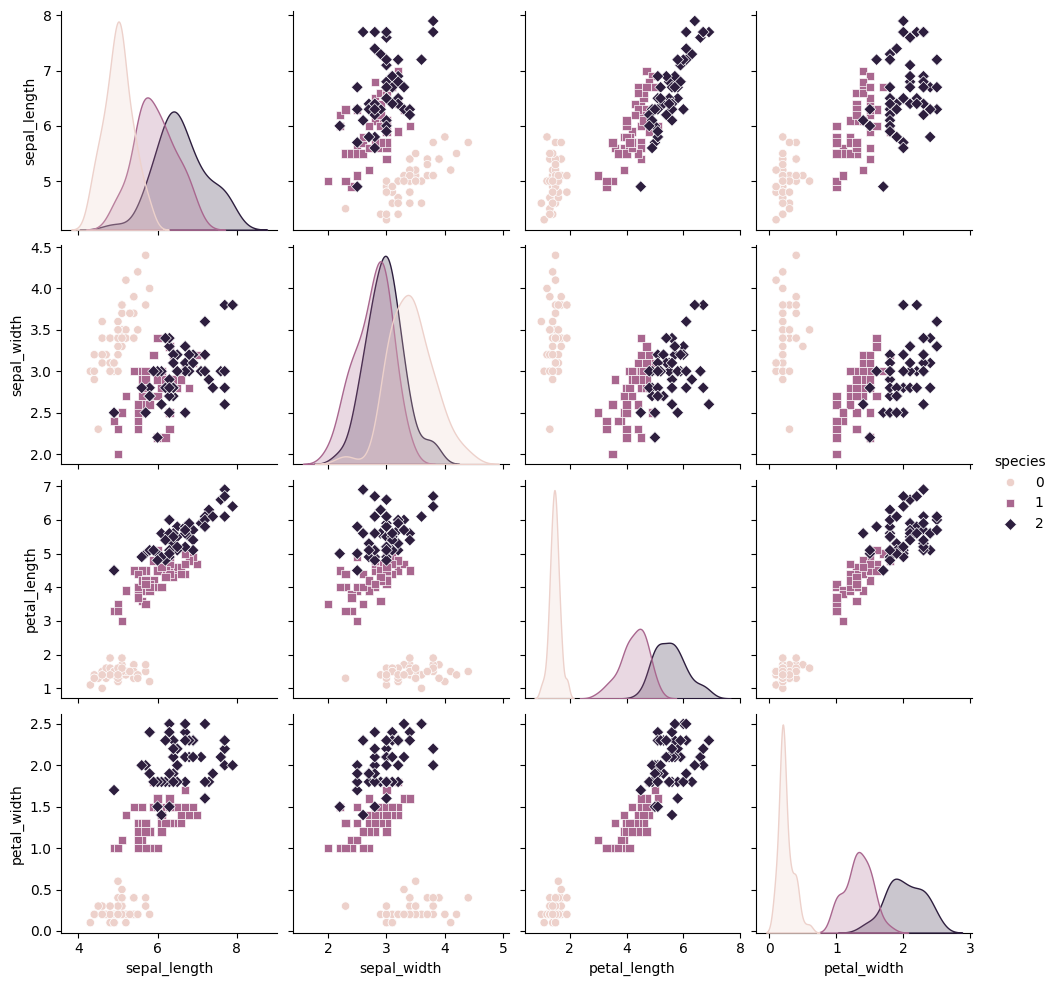

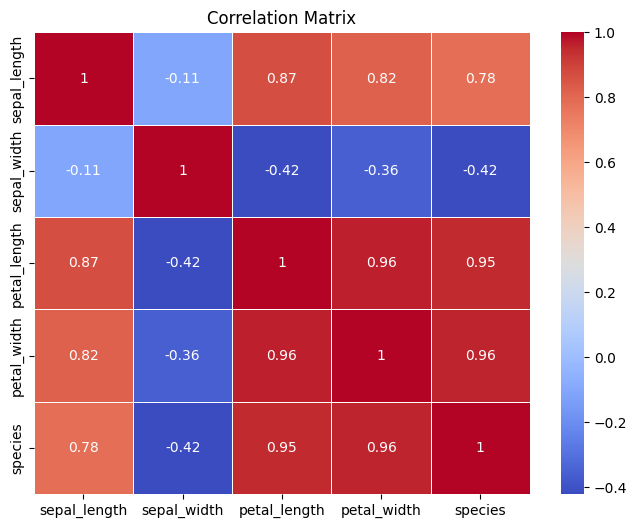

In [6]:
# Pair plot to see relationships
sns.pairplot(data, hue='species', markers=["o", "s", "D"])
plt.show()

# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [7]:


# Define features and target
X = data.drop('species', axis=1)
y = data['species']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the training and testing sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(120, 4) (30, 4) (120,) (30,)


In [8]:


# Initialize the model
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

In [9]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 1.0
Confusion Matrix:
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



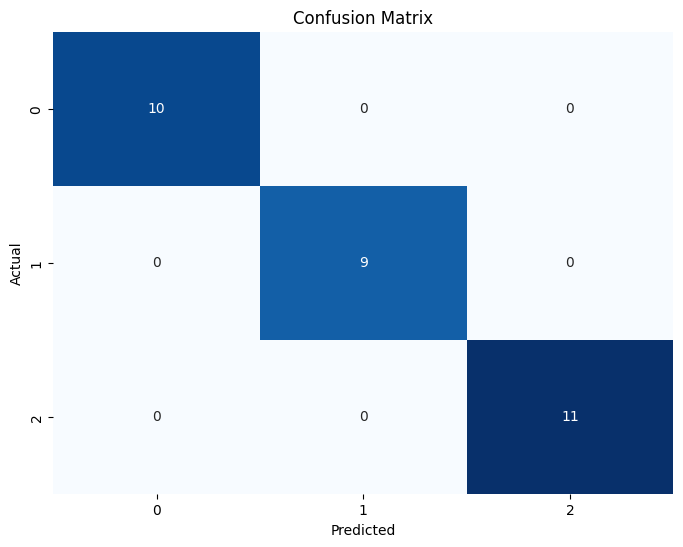

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()